In [2]:
!pip install ultralytics timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.7/644.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
from ultralytics import YOLO
import cv2
import math
import os
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np

# Specify the directory where you want to save the frames
output_directory = "/content/output"

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load the YOLO model
model = YOLO("/content/yolov8l.pt")

# Load the MiDaS model from PyTorch Hub
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").eval()

# Customized class names for campus navigation
classNames = ["person", "bicycle", "car", "motorbike","bus","truck", "tie"]

# Function to calculate depth map using the MiDaS model
def calculate_depth_map(image):
    # Resize the input image to the required size
    transform = T.Compose([T.Resize(384), T.ToTensor()])
    input_image = transform(Image.fromarray(image)).unsqueeze(0)

    with torch.no_grad():
        prediction = midas(input_image)

    depth_map = prediction.squeeze().cpu().numpy()
    depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)

    # Adjust the scaling factor based on the MiDaS model's output
    scaling_factor = 0.01
    depth_map = depth_map * scaling_factor

    return depth_map


import numpy as np

def calculate_distance(x1, y1, x2, y2, depth_map):
    # Define the region of interest within the bounding box
    roi = depth_map[y1:y2, x1:x2]

    # Calculate the weighted average depth within the region
    y, x = np.indices(roi.shape)
    total_depth = np.sum(roi)
    weighted_x = np.sum(x * roi)
    weighted_y = np.sum(y * roi)

    if total_depth > 0:
        center_x = x1 + weighted_x / total_depth
        center_y = y1 + weighted_y / total_depth
        distance = roi[int(center_y - y1), int(center_x - x1)]
        return distance
    else:
        # Handle the case where there is no valid depth information in the region
        return None


# Define camera parameters (example values, replace with your actual camera parameters)
focal_length = 35.0  # Focal length in millimeters
camera_center_x = 320  # Optical center's x-coordinate in the image frame
camera_center_y = 240  # Optical center's y-coordinate in the image frame

# Define a dictionary to keep track of detected objects per class
detected_objects_per_class = {}

def process_image(image, camera_center_x, camera_center_y, focal_length):
    depth_map = calculate_depth_map(image)

    results = model(image)

    detected_objects = {}
    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            w, h = x2 - x1, y2 - y1
            conf = math.ceil((box.conf[0] * 100)) / 100
            cls = int(box.cls[0])
            if 0 <= cls < len(classNames):
                object_class = classNames[cls]
            else:
                object_class = "Unknown"

            # Calculate the percentage of the image size covered by the bounding box
            image_area = image.shape[0] * image.shape[1]
            box_area = w * h
            coverage_percentage = (box_area / image_area) * 100

            # Choose the color based on coverage percentage
            if coverage_percentage > 50:
                color = (0, 0, 255)  # Red
            else:
                color = (0, 255, 0)  # Green

            # Check if we have detected objects of this class before
            if object_class not in detected_objects_per_class:
                detected_objects_per_class[object_class] = 1
            else:
                detected_objects_per_class[object_class] += 1

            # Assign a unique label to this object instance within the class
            object_name = f"{object_class}{detected_objects_per_class[object_class]}"

            # Calculate the distance using the depth map
            distance = calculate_distance(x1, y1, x2, y2, depth_map)

            # Calculate horizontal and vertical deviations in degrees
            horizontal_deviation = math.degrees(math.atan((x1 + w/2 - camera_center_x) / focal_length))
            vertical_deviation = math.degrees(math.atan((y1 + h/2 - camera_center_y) / focal_length))

            detected_objects[object_name] = {
                'distance': distance,
                'horizontal_deviation': horizontal_deviation,
                'vertical_deviation': vertical_deviation
            }

            # Draw bounding boxes and labels on the image with the chosen color
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, f"{object_name} ({conf:.2f})", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image, detected_objects

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [31]:
# Load your image file
ima = cv2.imread("/content/me.jpg")

image = cv2.resize(ima, (384, 384))

In [ ]:
!pip install utils

In [ ]:
model.info()

YOLOv8l summary (fused): 268 layers, 43668288 parameters, 0 gradients, 165.2 GFLOPs


(268, 43668288, 0, 165.1567104)


0: 640x640 3 persons, 1 tie, 2940.0ms
Speed: 6.7ms preprocess, 2940.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


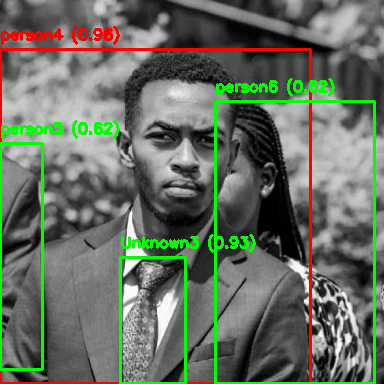

In [32]:
# Process the image and get detected objects, the modified image, and object distances
processed_image, detected_objects = process_image(image, camera_center_x, camera_center_y, focal_length)


# Display the modified image
from google.colab.patches import cv2_imshow
cv2_imshow(processed_image)


In [24]:
print(detected_objects)

{'Unknown1': {'distance': 1.7469708, 'horizontal_deviation': -78.19756579221645, 'vertical_deviation': 66.10483858492964}, 'person1': {'distance': 1.6255251, 'horizontal_deviation': -77.27564431457763, 'vertical_deviation': -36.6070748126075}, 'person2': {'distance': 0.73787427, 'horizontal_deviation': -83.31243776766402, 'vertical_deviation': 27.216111557307475}}


In [29]:
import pandas as pd

data = pd.DataFrame(detected_objects)


In [30]:
data.head()

,person1,Unknown1,person2,person3,Unknown2
distance,1.496324,1.583972,0.483331,1.515428,1.739343
horizontal_deviation,-77.660913,-78.265662,-83.290163,-37.130924,-75.095705
vertical_deviation,-34.992020,65.695451,30.358115,0.000000,6.519802
